

> Andrés Delicado Escudero



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Data preprocessing

We will work with a database of mnist digits from kaggle (https://www.kaggle.com/datasets/oddrationale/mnist-in-csv). The database is of type .csv. First we have convert it to .xlsx, as the information is separed by commas and we wanted on each row the data regarding each image (number).
At the end, we have a two datasets, one for training and another for testing, each one has at each row, first the label of the number, and then 784 features, one for each of the 28x28 pixeles of each image

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from skimage import metrics

# Read the CSV file
mnist_train = pd.read_excel('/content/drive/My Drive/Project Neural Networks/mnist_train.xlsx')
mnist_test = pd.read_excel('/content/drive/My Drive/Project Neural Networks/mnist_test.xlsx')



In [ ]:
# We extract the train data
X_train = mnist_train.iloc[:, 1:].values  # characteristics of the number
y_train = mnist_train.iloc[:, 0].values   # We also extract the label of the number, although we know we are not going to use it for anything
# We extract the test data
X_test = mnist_test.iloc[:, 1:].values    # characteristics of the number
y_test = mnist_test.iloc[:, 0].values     # We also extract the label of the number, although we know we are not going to use it for anything

# Normalice the pixel values on the range [0, 1]
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# Data dimensions
print('Dimensions of X_train:', X_train.shape)
print('Dimensions of y_train:', y_train.shape)
print('Dimensions of X_test:', X_test.shape)
print('Dimensions of y_test:', y_test.shape)

Dimensions of X_train: (60000, 784)
Dimensions of y_train: (60000,)
Dimensions of X_test: (10000, 784)
Dimensions of y_test: (10000,)


In [ ]:
# Function to randomize both the training and test

def permutate(X_train, X_test):

  permutation = np.random.permutation(len(X_train))
  X_train = X_train[permutation]
  permutation = np.random.permutation(len(X_test))
  X_test = X_test[permutation]

  return

# 2. Creating the autoencoder

## 2.1 Some useful functions


First we create some functions usefull for the **plotting of images**

In [ ]:
#We will use this function to compute the two numbers to reshape any type of dimension we want automatically
# It returns the two lowest divisors of the shape of an array
def compute_new_dimensions(shape):
    # Total number of elements of original array
    total_elementos = np.prod(shape)

    # Near divisors
    for i in range(int(np.sqrt(total_elementos)), 0, -1):
        if total_elementos % i == 0:
            divisor1 = i
            divisor2 = total_elementos // i
            return divisor1, divisor2

In [ ]:
# Function for visualizing the original, then low dimensional reconstruction and finally, the reconstructed images
def plot_images(X_test,encoded_imgs, predicted_images, latent_dim, noisy=False, n_images=10):
    plt.figure(figsize=(40, 4))
    for i in range(n_images):

        n=3
        a=i + 1
        b=i + 1 + 20
        c=2*20 +i+ 1
        d=0
        if noisy==True:
          n=4
          a=i + 1
          d=i + 1+20
          b=2*20 +i+ 1
          c=3*20 +i+ 1

        # display original images
        ax = plt.subplot(n, 20, a)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if noisy==True:
          # display noised images
          ax = plt.subplot(n, 20, d)
          plt.imshow(X_test_noisy[i].reshape(28, 28))
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

        # display encoded images at the latent dimension
        ax = plt.subplot(n, 20, b)
        X,Y=compute_new_dimensions(np.array([0]*latent_dim).shape) #We must to consider that the latent dimensions could change
        plt.imshow(encoded_imgs[i].reshape(Y,X))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstructed images
        ax = plt.subplot(n, 20, c)
        plt.imshow(predicted_images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


    plt.show()

In [ ]:
#We will use them to compare models
from math import log

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0])
    return err

def ssim(imageA, imageB):
    return metrics.structural_similarity(imageA, imageB,channel_axis=None)

### 2.2 Peak signal-to-noise ratio (PSNR) as a performance metric

Peak signal-to-noise ratio (**PSNR**) is the ratio between the maximum possible power of an image and the power of corrupting noise that affects the quality of its representation. To estimate the PSNR of an image, it is necessary to compare that image to an ideal clean image with the maximum possible power. It uses the Mean Square Error. We will use it as a performance metric to train and test the denoising autoencoder.

In [ ]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    mse_value = tf.reduce_mean(tf.square(y_true - y_pred))
    psnr = 20. * tf.math.log(max_pixel / mse_value) #estudiar esto alomejor poner 20 al principio
    return psnr


### 2.3 Structure of the autoencoder

We know that our input data is a vector of 784 dimensions. But we do not know which is the optimal number of latent dimensions (the minimum number of dimensions till which our encoder will reduce our data). So, the optimum way to do it, is creating a class for the autoencoders that is created with a number of latent dimensions. In this way, we can use the structure of the autoencoder for creating different neural networks with different latent dimensions.

### 3x3 autoencoder

First, we are going to test an outoencoder with 5 hidden layers in total:
 3 for the encoder (including the input layer) and 3 for the decoder. The total number of layers is 5 because the last layer of the encoder (the one with the encoding of minimum number of dimension) is also the first layer of the decoder. So it is a shared layer between both.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
class Autoencoder_3x3(Model):
  def __init__(self, latent_dim, regularice=True):
    super(Autoencoder_3x3, self).__init__()
    self.latent_dim = latent_dim
    self.regularice = regularice
    if regularice:
      self.encoder = tf.keras.Sequential([
        layers.Dense(784, activation='relu'),
        layers.Dropout(1e-5, input_shape=(784,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(1e-5, input_shape=(128,)),
        layers.Dense(latent_dim, kernel_regularizer = regularizers.l1(1e-5),  activation='relu'), #kernel_regularizer = regularizers.l2(1e-3),
        layers.Dropout(1e-5, input_shape=(latent_dim,)),
      ])
      self.decoder = tf.keras.Sequential([

        layers.Dense(128, activation='relu'),
        layers.Dropout(1e-5, input_shape=(128,)),
        layers.Dense(784, kernel_regularizer=regularizers.l1_l2(1e-4, 1e-5), activation='sigmoid') #kernel_regularizer=regularizers.l1_l2(0.01, 0.01),
      ])
    else:
        self.encoder = tf.keras.Sequential([
        layers.Dense(784, activation='relu'),
        layers.Dropout(1e-5, input_shape=(784,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(1e-5, input_shape=(128,)),
        layers.Dense(latent_dim,  activation='relu'),
        layers.Dropout(1e-5, input_shape=(latent_dim,)),
      ])
        self.decoder = tf.keras.Sequential([

          layers.Dense(128, activation='relu'),
          layers.Dropout(1e-5, input_shape=(128,)),
          layers.Dense(784,  activation='sigmoid')
        ])


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Now we can create several autoencoders by varing the latent dimensions and compare them

#### Comments about the output:

At each itteraction we are going to see some metrics of the different models to analice them. So, at each iteraction for each model we have:

1.   Title of the number of latent dimensions of each model
2.   History of the training
3.  Two plots of the training history of the model. One shows the evolution of the Loss respect to the epochs and the other the evolution of the PSNR with the epochs
4. Structure of the autoencoder
5. A plot where we can see first the original images that where inputed to the model, below it the lowest dimensionality encodance of the image, and at the bottom the decoded image that our denoising autoencoder predicts (with out noise). That for several images.
6. Other metrics to analyce the performance of the model for different images.
7. 3 dictionarys, one for the mse, ssim and psnr metrics with the grouped data shown before


 Autoencoder with latent dimensions =  15
Epoch 1/15
118/118 [==============================] - 10s 74ms/step - loss: 0.4623 - PSNR: 53.6290 - val_loss: 0.2726 - val_PSNR: 61.2477
Epoch 2/15
118/118 [==============================] - 8s 66ms/step - loss: 0.2318 - PSNR: 64.3444 - val_loss: 0.2040 - val_PSNR: 66.7045
Epoch 3/15
118/118 [==============================] - 9s 75ms/step - loss: 0.1936 - PSNR: 67.6774 - val_loss: 0.1853 - val_PSNR: 68.4651
Epoch 4/15
118/118 [==============================] - 9s 76ms/step - loss: 0.1794 - PSNR: 69.2578 - val_loss: 0.1735 - val_PSNR: 70.0981
Epoch 5/15
118/118 [==============================] - 8s 66ms/step - loss: 0.1683 - PSNR: 71.1101 - val_loss: 0.1639 - val_PSNR: 71.8530
Epoch 6/15
118/118 [==============================] - 8s 71ms/step - loss: 0.1615 - PSNR: 72.3398 - val_loss: 0.1586 - val_PSNR: 72.8890
Epoch 7/15
118/118 [==============================] - 7s 58ms/step - loss: 0.1559 - PSNR: 73.5505 - val_loss: 0.1550 - val_PSNR: 73.51

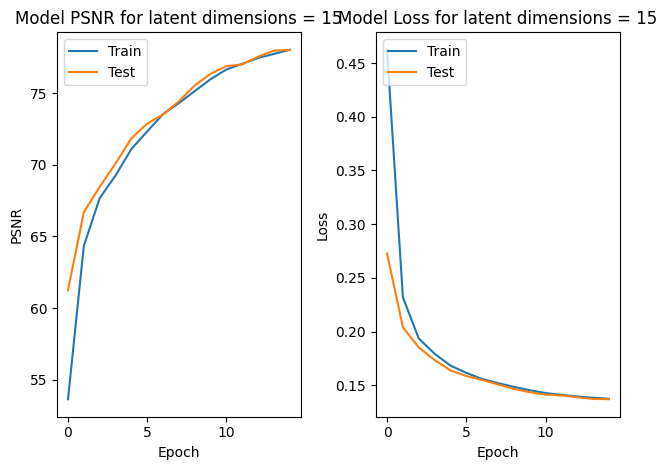

Model: "autoencoder_3x3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 15)                717855    
                                                                 
 sequential_1 (Sequential)   (None, 784)               103184    
                                                                 
Total params: 821039 (3.13 MB)
Trainable params: 821039 (3.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


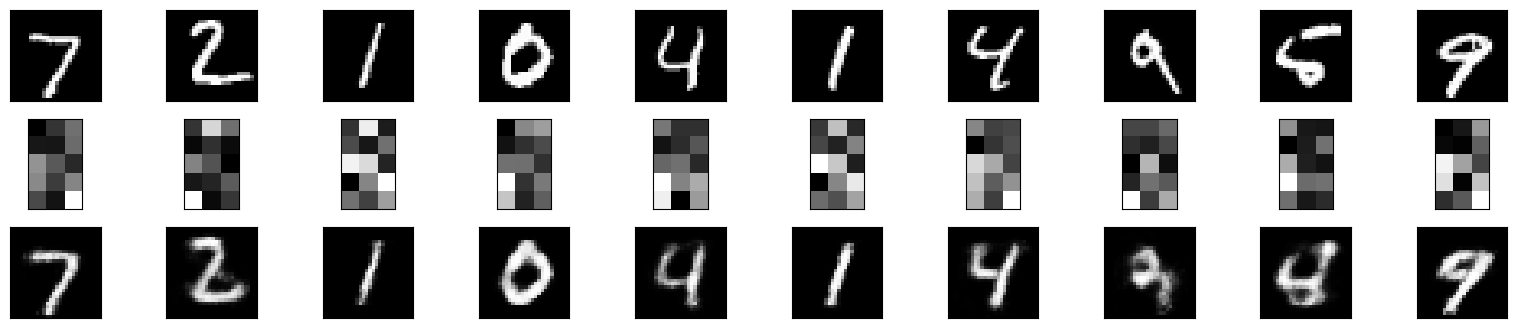

mse,ssim and psnr for image 0 are 0.009604980502610827, 0.8611318935389669 and 92.90947
mse,ssim and psnr for image 1 are 0.03456614537217683, 0.6871077767317235 and 67.29761
mse,ssim and psnr for image 2 are 0.004825855523919469, 0.9486116793504641 and 106.67535
mse,ssim and psnr for image 3 are 0.012645263394108836, 0.895602134656422 and 87.40945
mse,ssim and psnr for image 4 are 0.01356493003362503, 0.8309619349133042 and 86.005356
mse,ssim and psnr for image 5 are 0.0031381536727987484, 0.9595771990907989 and 115.28241
mse,ssim and psnr for image 6 are 0.02598518457372923, 0.7725580929244547 and 73.00458
mse,ssim and psnr for image 7 are 0.03187056438128444, 0.694669390970525 and 68.92145
mse,ssim and psnr for image 8 are 0.05860793557904798, 0.5878783291386952 and 56.737705
mse,ssim and psnr for image 9 are 0.016270891204265937, 0.844519919220084 and 82.36755
{7: 0.01, 2: 0.035, 1: 0.003, 0: 0.013, 4: 0.026, 9: 0.016, 5: 0.059}
{7: 0.861, 2: 0.687, 1: 0.96, 0: 0.896, 4: 0.773, 9: 

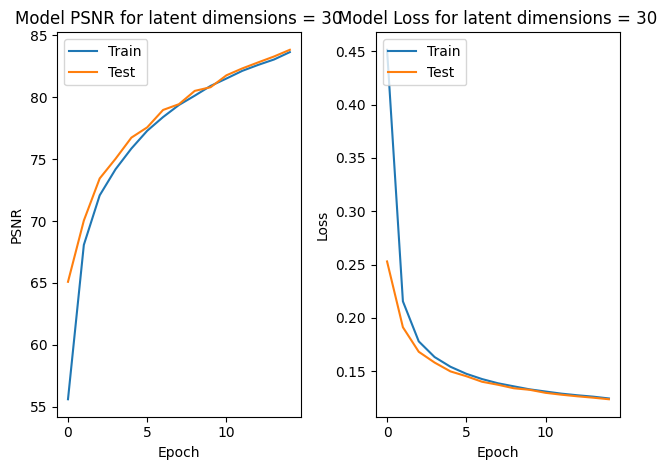

Model: "autoencoder_3x3_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 30)                719790    
                                                                 
 sequential_3 (Sequential)   (None, 784)               105104    
                                                                 
Total params: 824894 (3.15 MB)
Trainable params: 824894 (3.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


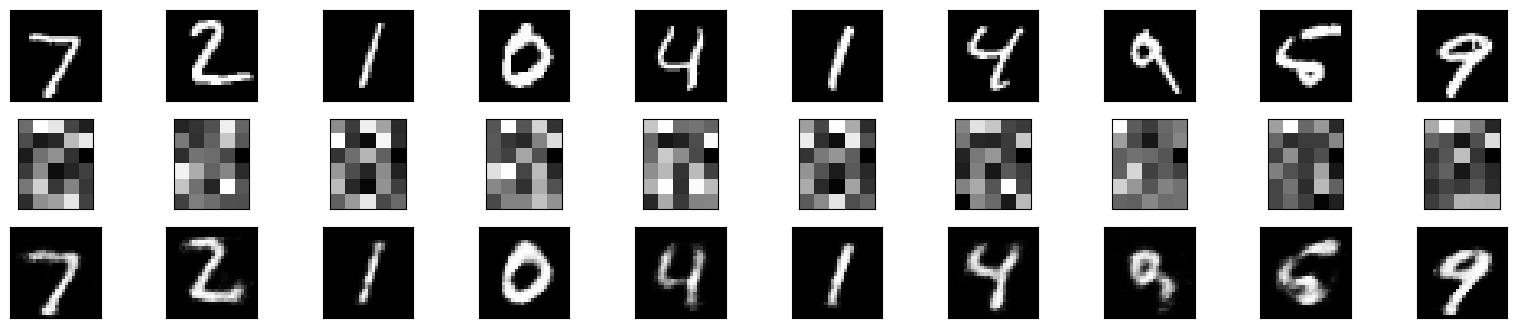

mse,ssim and psnr for image 0 are 0.007880238119333846, 0.870886168536936 and 96.86794
mse,ssim and psnr for image 1 are 0.024111609100651188, 0.7452861860732726 and 74.501236
mse,ssim and psnr for image 2 are 0.003965289215697277, 0.950782125796596 and 110.60353
mse,ssim and psnr for image 3 are 0.010680873201964857, 0.9150407421848543 and 90.78601
mse,ssim and psnr for image 4 are 0.01609216517717583, 0.8215168361300076 and 82.588455
mse,ssim and psnr for image 5 are 0.0022165715682292, 0.9715084267306144 and 122.23587
mse,ssim and psnr for image 6 are 0.02018562192015828, 0.7948838257539663 and 78.055695
mse,ssim and psnr for image 7 are 0.025696399001991894, 0.7621671056101377 and 73.22809
mse,ssim and psnr for image 8 are 0.03265621550305964, 0.6965745254696567 and 68.4344
mse,ssim and psnr for image 9 are 0.01494007419376878, 0.8695166755768717 and 84.074165
{7: 0.008, 2: 0.024, 1: 0.002, 0: 0.011, 4: 0.02, 9: 0.015, 5: 0.033}
{7: 0.871, 2: 0.745, 1: 0.972, 0: 0.915, 4: 0.795, 9:

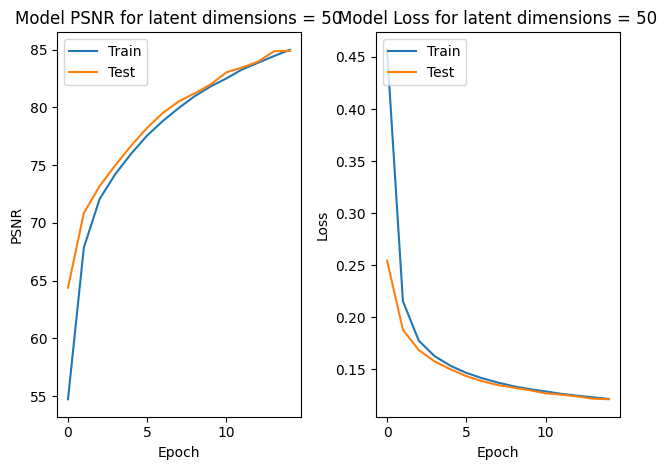

Model: "autoencoder_3x3_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 50)                722370    
                                                                 
 sequential_5 (Sequential)   (None, 784)               107664    
                                                                 
Total params: 830034 (3.17 MB)
Trainable params: 830034 (3.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


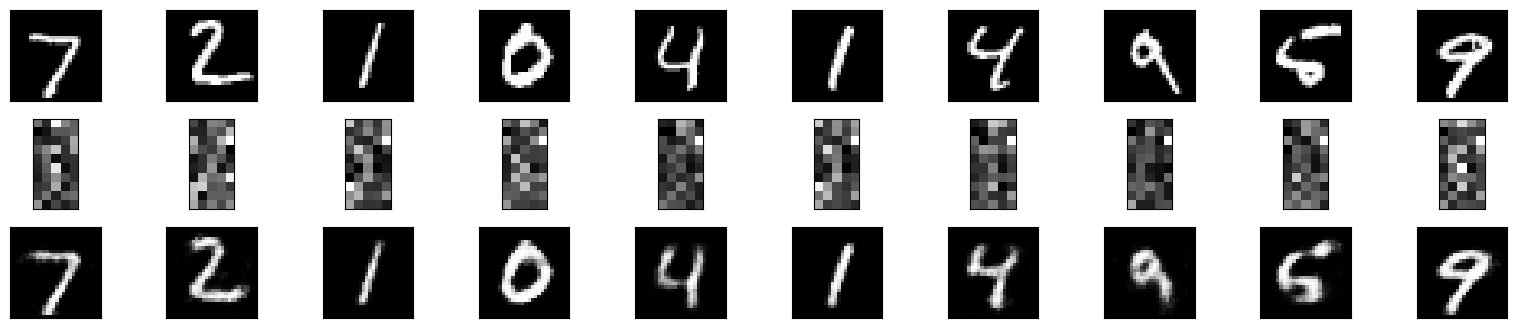

mse,ssim and psnr for image 0 are 0.005478947419418779, 0.9017596020851677 and 104.13685
mse,ssim and psnr for image 1 are 0.019686512499575853, 0.7851137847691693 and 78.556435
mse,ssim and psnr for image 2 are 0.0027814200272043513, 0.9643340828639376 and 117.69588
mse,ssim and psnr for image 3 are 0.011646705405435805, 0.9125416154317363 and 89.054634
mse,ssim and psnr for image 4 are 0.012004318530615638, 0.8574355579326097 and 88.449776
mse,ssim and psnr for image 5 are 0.0014819000668551447, 0.9799687983444233 and 130.2886
mse,ssim and psnr for image 6 are 0.017835459674610435, 0.8163196930931438 and 80.53134
mse,ssim and psnr for image 7 are 0.019773062023720842, 0.8022505041748431 and 78.4687
mse,ssim and psnr for image 8 are 0.041208508753010305, 0.709011946164874 and 63.78221
mse,ssim and psnr for image 9 are 0.010178267414638313, 0.903595346526499 and 91.750015
{7: 0.005, 2: 0.02, 1: 0.001, 0: 0.012, 4: 0.018, 9: 0.01, 5: 0.041}
{7: 0.902, 2: 0.785, 1: 0.98, 0: 0.913, 4: 0.8

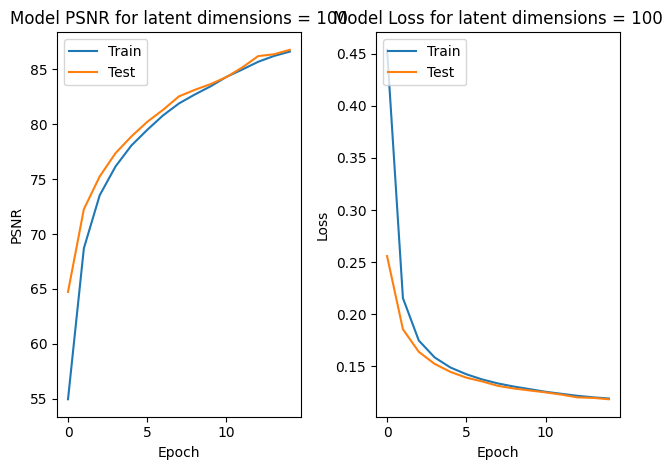

Model: "autoencoder_3x3_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 100)               728820    
                                                                 
 sequential_7 (Sequential)   (None, 784)               114064    
                                                                 
Total params: 842884 (3.22 MB)
Trainable params: 842884 (3.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


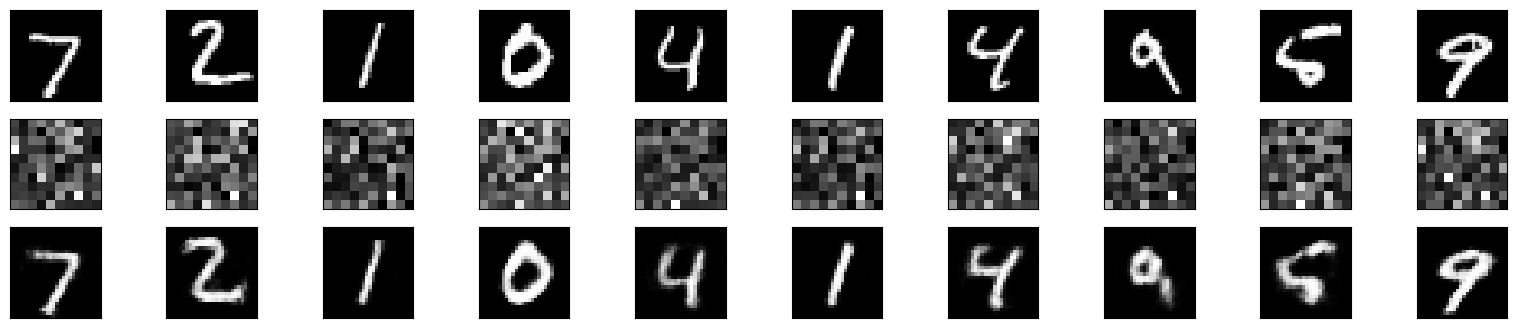

mse,ssim and psnr for image 0 are 0.006838039186109787, 0.8877202459044783 and 99.705086
mse,ssim and psnr for image 1 are 0.02519456608416588, 0.753453067897959 and 73.622536
mse,ssim and psnr for image 2 are 0.0031647066597616934, 0.9640563535755429 and 115.1139
mse,ssim and psnr for image 3 are 0.010047886339827667, 0.9149757138768254 and 92.007866
mse,ssim and psnr for image 4 are 0.012494403748157823, 0.8340845172303061 and 87.64949
mse,ssim and psnr for image 5 are 0.0016447277885634844, 0.9695343260670076 and 128.20361
mse,ssim and psnr for image 6 are 0.012721381905330127, 0.8351539961142576 and 87.28942
mse,ssim and psnr for image 7 are 0.019002342914404387, 0.8295230626363614 and 79.263855
mse,ssim and psnr for image 8 are 0.027687262262043714, 0.7413477659323324 and 71.73566
mse,ssim and psnr for image 9 are 0.010973213959249342, 0.8917656687016038 and 90.245964
{7: 0.007, 2: 0.025, 1: 0.002, 0: 0.01, 4: 0.013, 9: 0.011, 5: 0.028}
{7: 0.888, 2: 0.753, 1: 0.97, 0: 0.915, 4: 0

In [ ]:
import matplotlib.pyplot as plt
import time

latent_dimendios=[15,30,50,100]
training_times=[]
mean_psnr=[]
autoencoder=False
epochs=15

for latent_dim in latent_dimendios:

  if autoencoder:
    del autoencoder

  permutate(X_train, X_test)

  print('\n Autoencoder with latent dimensions = ', latent_dim)
  autoencoder=Autoencoder_3x3(latent_dim)
  history=autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=[PSNR])
  # Train the autoencoder
  initial_time=time.time()
  history=autoencoder.fit(X_train, X_train, #We use the same data matrix X_train
                                          #for both the input and output data during the training of the autoencoder
                                          # because the goal is to reconstruct the input as faithfully as possible at the output.
                    epochs=epochs,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(X_test, X_test))

  final_time=time.time()
  training_time=final_time-initial_time
  training_times.append(training_time)

  # Plot PSNR
  plt.subplot(1, 2, 1)
  plt.plot(history.history['PSNR'])
  plt.plot(history.history['val_PSNR'])
  plt.title('Model PSNR for latent dimensions = '+ str(latent_dim))
  plt.ylabel('PSNR')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Plot Loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss for latent dimensions = '+ str(latent_dim))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.tight_layout()
  plt.show()

  autoencoder.summary()
  encoded_imgs = autoencoder.encoder(X_test).numpy()
  decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

  plot_images(X_test,encoded_imgs, decoded_imgs, latent_dim)

  #Another way to see it
  decomser = {}
  decossimr = {}
  decopsnr = {}
  n = 10
  list_xtestn = [ [X_test[i], y_test[i]] for i in range(10)]

  for i in range(n):

      msel = mse(list_xtestn[i][0],decoded_imgs[i])
      decomser[list_xtestn[i][1]]=round(msel,3)

      ssiml = ssim(list_xtestn[i][0],decoded_imgs[i])
      decossimr[list_xtestn[i][1]]=round(ssiml,3)

      psnr = PSNR(list_xtestn[i][0],decoded_imgs[i]).numpy()
      decopsnr[list_xtestn[i][1]]=round(psnr,3)

      print("mse,ssim and psnr for image %s are %s, %s and %s" %(i,msel,ssiml, psnr))

  mean_psnr.append(np.mean(list(decopsnr.values())))

  print(decomser)
  print(decossimr)
  print(decopsnr)


We have creted also some arrays to check the time the training of each model took, which is a fundamental point to consider on neural networks. Also is shows the mean psnr for 10 images for each dmodel with different latent variables

In [ ]:
for i, indice in enumerate(latent_dimendios):
    tiempo_entrenamiento = training_times[i]
    psnr=mean_psnr[i]
    print("Number of latent dimensions:", indice, " - Training time:", tiempo_entrenamiento, "- mean PSNR:", psnr)

Number of latent dimensions: 15  - Training time: 144.51246166229248 - mean PSNR: 82.14414
Number of latent dimensions: 30  - Training time: 144.08950304985046 - mean PSNR: 87.850716
Number of latent dimensions: 50  - Training time: 143.8761830329895 - mean PSNR: 91.15714
Number of latent dimensions: 100  - Training time: 130.1457703113556 - mean PSNR: 91.83014


### 5x5 autoencoder

Now, following the same procedure, we are going to test the performance of an autoencoder with more hidden layers.

In [ ]:
class Autoencoder_5x5(Model):
  def __init__(self, latent_dim):
    super(Autoencoder_5x5, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Dense(784, activation='relu'),
      layers.Dropout(1e-5, input_shape=(784,)),
      layers.Dense(512, activation='relu'),
      layers.Dropout(1e-5, input_shape=(512,)),
      layers.Dense(256, activation='relu'),
      layers.Dropout(1e-5, input_shape=(256,)),
      layers.Dense(128, activation='relu'),
      layers.Dropout(1e-5, input_shape=(128,)),
      layers.Dense(latent_dim, kernel_regularizer = regularizers.l2(1e-5),  activation='relu'), #kernel_regularizer = regularizers.l2(1e-3),
      layers.Dropout(1e-5, input_shape=(latent_dim,)),
    ])
    self.decoder = tf.keras.Sequential([

      layers.Dense(128, activation='relu'),
      layers.Dropout(1e-5, input_shape=(128,)),
      layers.Dense(256, activation='relu'),
      layers.Dropout(1e-5, input_shape=(256,)),
      layers.Dense(512, activation='relu'),
      layers.Dropout(1e-5, input_shape=(512,)),
      layers.Dense(784, kernel_regularizer=regularizers.l1_l2(1e-4, 1e-5), activation='sigmoid') #kernel_regularizer=regularizers.l1_l2(0.01, 0.01),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


#### Comments about the output (same as before):

At each itteraction we are going to see some metrics of the different models to analice them. So, at each iteraction for each model we have:

1.   Title of the number of latent dimensions of each model
2.   History of the training
3.  Two plots of the training history of the model. One shows the evolution of the Loss respect to the epochs and the other the evolution of the PSNR with the epochs
4. Structure of the autoencoder
5. A plot where we can see first the original images that where inputed to the model, below it the lowest dimensionality encodance of the image, and at the bottom the decoded image that our denoising autoencoder predicts (with out noise). That for several images.
6. Other metrics to analyce the performance of the model for different images.
7. 3 dictionarys, one for the mse, ssim and psnr metrics with the grouped data shown before


 Autoencoder with latent dimensions =  100
Epoch 1/15
118/118 [==============================] - 20s 144ms/step - loss: 0.6891 - PSNR: 53.1093 - val_loss: 0.2979 - val_PSNR: 58.2096
Epoch 2/15
118/118 [==============================] - 17s 145ms/step - loss: 0.2441 - PSNR: 62.4684 - val_loss: 0.2084 - val_PSNR: 65.9617
Epoch 3/15
118/118 [==============================] - 17s 147ms/step - loss: 0.1943 - PSNR: 67.6006 - val_loss: 0.1804 - val_PSNR: 69.5498
Epoch 4/15
118/118 [==============================] - 18s 155ms/step - loss: 0.1724 - PSNR: 70.9328 - val_loss: 0.1672 - val_PSNR: 71.6055
Epoch 5/15
118/118 [==============================] - 17s 147ms/step - loss: 0.1621 - PSNR: 72.6941 - val_loss: 0.1580 - val_PSNR: 73.5076
Epoch 6/15
118/118 [==============================] - 18s 149ms/step - loss: 0.1550 - PSNR: 74.1527 - val_loss: 0.1517 - val_PSNR: 74.7490
Epoch 7/15
118/118 [==============================] - 17s 142ms/step - loss: 0.1499 - PSNR: 75.2013 - val_loss: 0.1483 - v

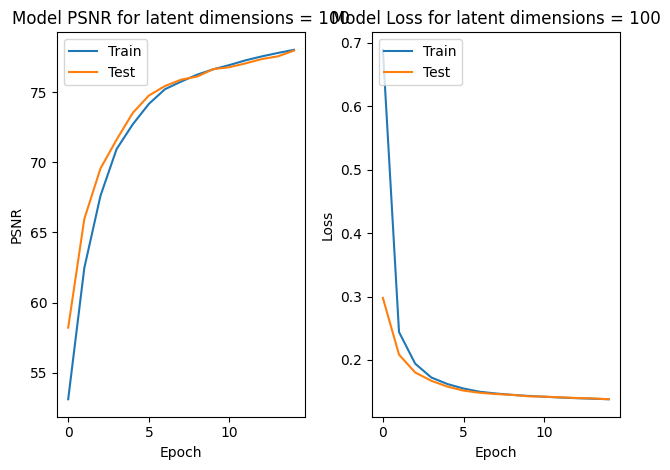

Model: "autoencoder_5x5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 100)               1194484   
                                                                 
 sequential_9 (Sequential)   (None, 784)               579728    
                                                                 
Total params: 1774212 (6.77 MB)
Trainable params: 1774212 (6.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


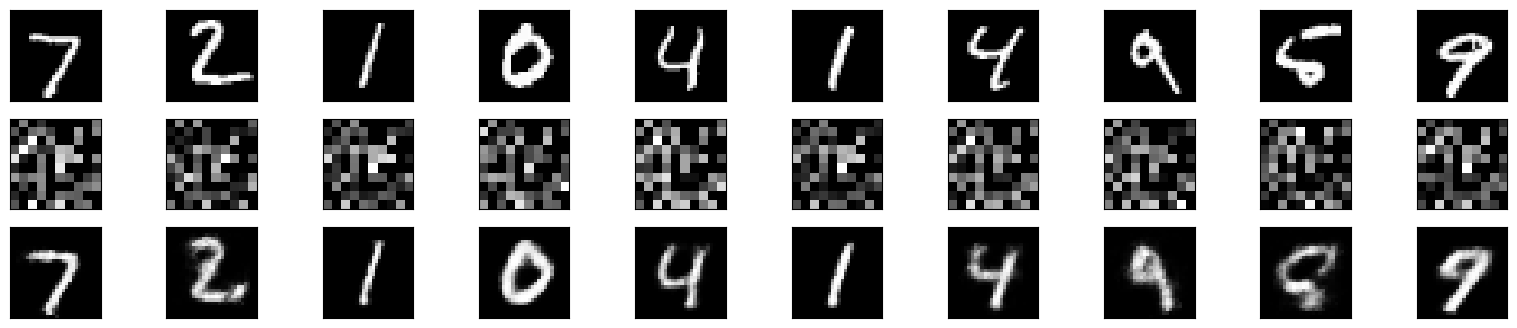

mse,ssim and psnr for image 0 are 0.01035293003935894, 0.8775302295073727 and 91.40971
mse,ssim and psnr for image 1 are 0.026994762166719893, 0.715808407814508 and 72.24225
mse,ssim and psnr for image 2 are 0.002783379435351633, 0.966514765852368 and 117.68179
mse,ssim and psnr for image 3 are 0.015100281392740897, 0.8784503986878538 and 83.86084
mse,ssim and psnr for image 4 are 0.011626085348965292, 0.8598807360534018 and 89.09008
mse,ssim and psnr for image 5 are 0.0016816185152456855, 0.9762944794501774 and 127.75997
mse,ssim and psnr for image 6 are 0.031139679239283354, 0.7509629706082869 and 69.385445
mse,ssim and psnr for image 7 are 0.028390055543523682, 0.7329663187563542 and 71.23433
mse,ssim and psnr for image 8 are 0.061109230624809344, 0.5594715534553569 and 55.901848
mse,ssim and psnr for image 9 are 0.01921413537631725, 0.8388894531554285 and 79.04218
{7: 0.01, 2: 0.027, 1: 0.002, 0: 0.015, 4: 0.031, 9: 0.019, 5: 0.061}
{7: 0.878, 2: 0.716, 1: 0.976, 0: 0.878, 4: 0.751

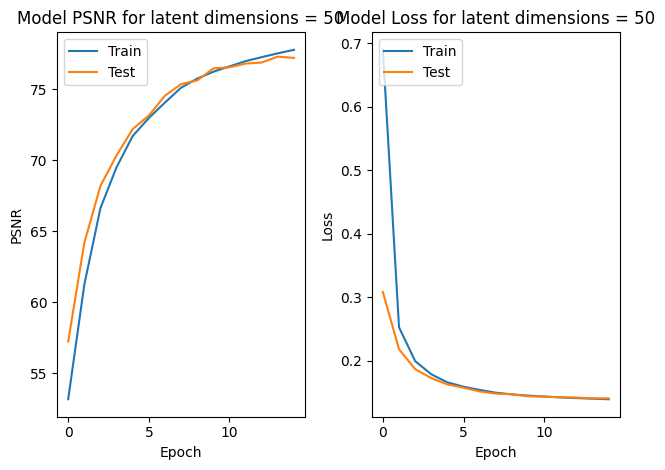

Model: "autoencoder_5x5_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 50)                1188034   
                                                                 
 sequential_11 (Sequential)  (None, 784)               573328    
                                                                 
Total params: 1761362 (6.72 MB)
Trainable params: 1761362 (6.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


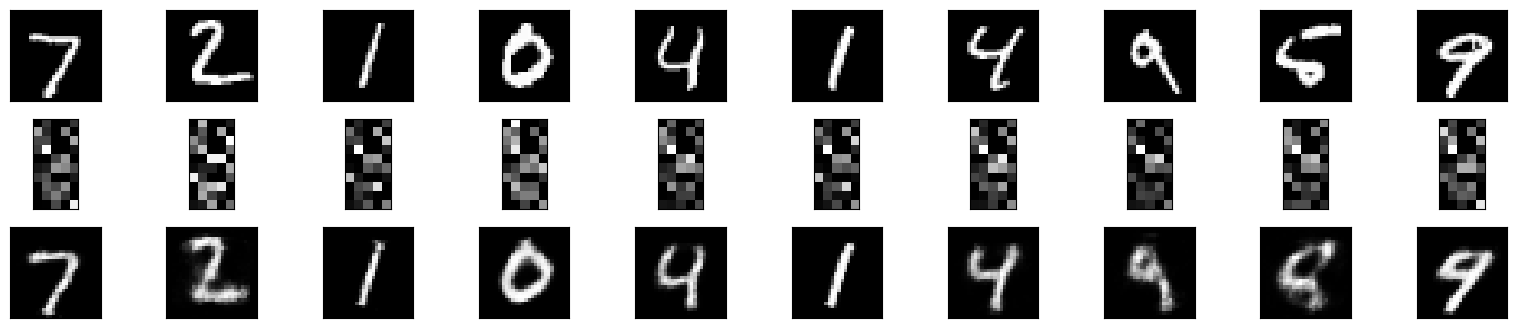

mse,ssim and psnr for image 0 are 0.011470179138892908, 0.8695914059629227 and 89.36009
mse,ssim and psnr for image 1 are 0.03195591071601338, 0.6592673577369681 and 68.86796
mse,ssim and psnr for image 2 are 0.0029961829466500865, 0.9582609097864766 and 116.20833
mse,ssim and psnr for image 3 are 0.014933216200388842, 0.8745275583144536 and 84.08334
mse,ssim and psnr for image 4 are 0.013498602323321304, 0.8649879766940582 and 86.10338
mse,ssim and psnr for image 5 are 0.0015957897854503862, 0.9833108984079969 and 128.80772
mse,ssim and psnr for image 6 are 0.02797692745666101, 0.7699372043682773 and 71.527504
mse,ssim and psnr for image 7 are 0.0327080820465597, 0.7318770874177637 and 68.402664
mse,ssim and psnr for image 8 are 0.06352569079517549, 0.5235106202835923 and 55.12622
mse,ssim and psnr for image 9 are 0.01760250954947374, 0.8354597060805292 and 80.79428
{7: 0.011, 2: 0.032, 1: 0.002, 0: 0.015, 4: 0.028, 9: 0.018, 5: 0.064}
{7: 0.87, 2: 0.659, 1: 0.983, 0: 0.875, 4: 0.77, 

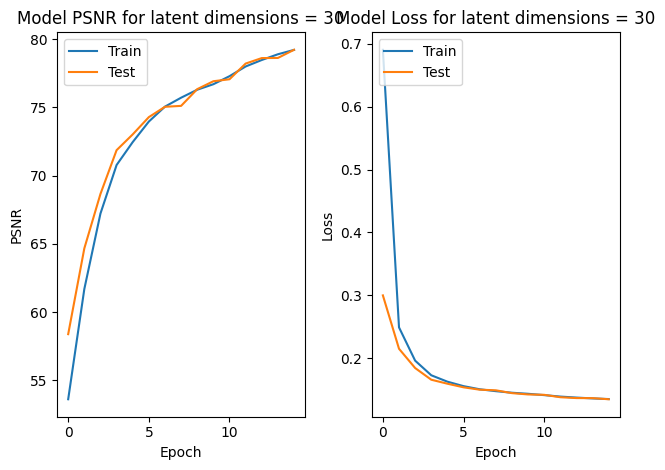

Model: "autoencoder_5x5_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 30)                1185454   
                                                                 
 sequential_13 (Sequential)  (None, 784)               570768    
                                                                 
Total params: 1756222 (6.70 MB)
Trainable params: 1756222 (6.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


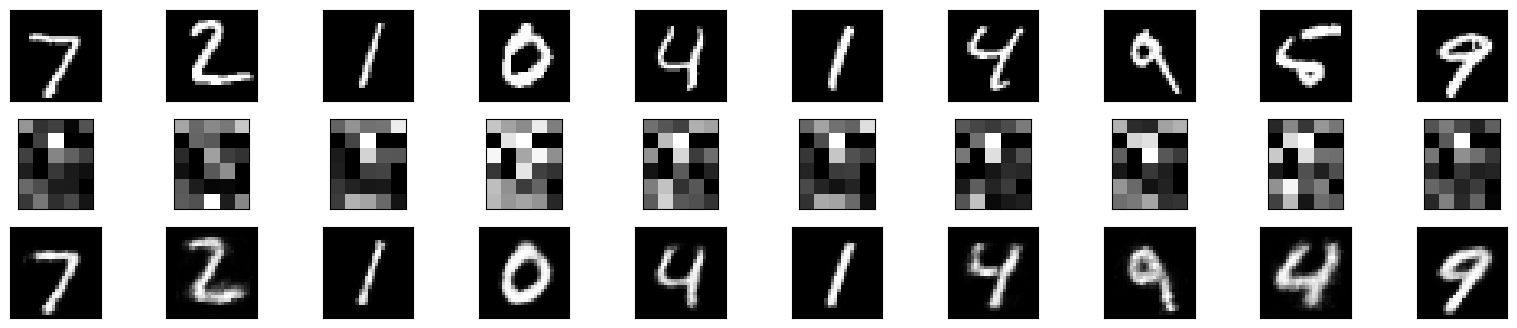

mse,ssim and psnr for image 0 are 0.008806415690080324, 0.8949683974414722 and 94.6455
mse,ssim and psnr for image 1 are 0.027370213499676055, 0.7069035987860516 and 71.966
mse,ssim and psnr for image 2 are 0.003943177594756405, 0.96005555984126 and 110.71537
mse,ssim and psnr for image 3 are 0.010503197856584432, 0.9081546815317532 and 91.12151
mse,ssim and psnr for image 4 are 0.009210826550438983, 0.8873171442138046 and 93.74751
mse,ssim and psnr for image 5 are 0.0018809040276775194, 0.9701669912565031 and 125.52006
mse,ssim and psnr for image 6 are 0.019681750909444094, 0.7977465148718913 and 78.561264
mse,ssim and psnr for image 7 are 0.02494610437516463, 0.7770553379946238 and 73.820755
mse,ssim and psnr for image 8 are 0.08218298931079873, 0.4986523363545869 and 49.97614
mse,ssim and psnr for image 9 are 0.018901667523825588, 0.8513991990425601 and 79.3701
{7: 0.009, 2: 0.027, 1: 0.002, 0: 0.011, 4: 0.02, 9: 0.019, 5: 0.082}
{7: 0.895, 2: 0.707, 1: 0.97, 0: 0.908, 4: 0.798, 9: 

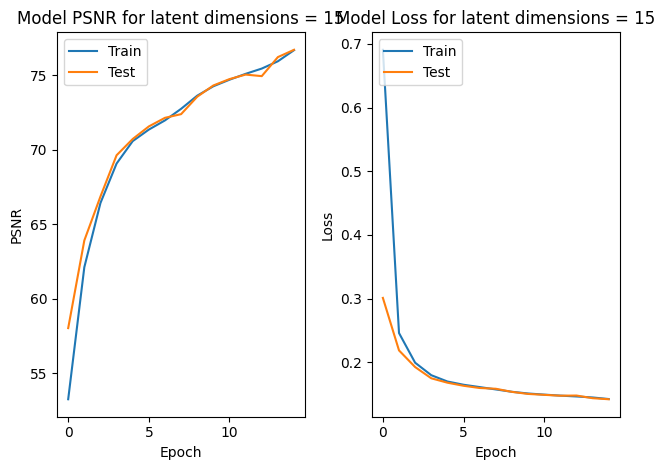

Model: "autoencoder_5x5_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 15)                1183519   
                                                                 
 sequential_15 (Sequential)  (None, 784)               568848    
                                                                 
Total params: 1752367 (6.68 MB)
Trainable params: 1752367 (6.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


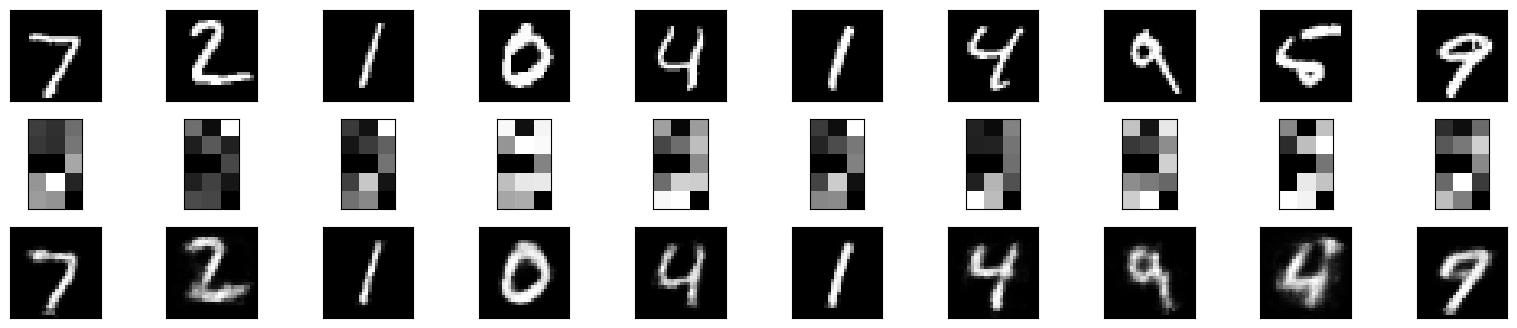

mse,ssim and psnr for image 0 are 0.011415323510484231, 0.8713400146973638 and 89.45598
mse,ssim and psnr for image 1 are 0.03592935530186923, 0.6671705480653671 and 66.52401
mse,ssim and psnr for image 2 are 0.0031453469877931696, 0.965130499576082 and 115.236626
mse,ssim and psnr for image 3 are 0.014370330310922871, 0.8933326446652954 and 84.85179
mse,ssim and psnr for image 4 are 0.013465182963233586, 0.8664274331676632 and 86.15296
mse,ssim and psnr for image 5 are 0.0026222504617706916, 0.96713908881447 and 118.87444
mse,ssim and psnr for image 6 are 0.022344859263072087, 0.7493757705442406 and 76.023186
mse,ssim and psnr for image 7 are 0.0317062455517756, 0.7125711099836906 and 69.02483
mse,ssim and psnr for image 8 are 0.07152967993470494, 0.37737145238858755 and 52.752857
mse,ssim and psnr for image 9 are 0.019105174425540414, 0.8433230042051398 and 79.15592
{7: 0.011, 2: 0.036, 1: 0.003, 0: 0.014, 4: 0.022, 9: 0.019, 5: 0.072}
{7: 0.871, 2: 0.667, 1: 0.967, 0: 0.893, 4: 0.74

In [ ]:
import matplotlib.pyplot as plt
import time

latent_dimendios=[100,50,30,15]
training_times=[]
mean_psnr=[]
epochs=15

for latent_dim in latent_dimendios:

  if autoencoder:
    del autoencoder

  permutate(X_train,X_test)

  print('\n Autoencoder with latent dimensions = ', latent_dim)
  autoencoder=Autoencoder_5x5(latent_dim)
  history=autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=[PSNR])
  # Train the autoencoder
  initial_time=time.time()
  history=autoencoder.fit(X_train, X_train, #We use the same data matrix X_train
                                          #for both the input and output data during the training of the autoencoder.
                                          # because the goal is to reconstruct the input as faithfully as possible at the output.
                    epochs=epochs,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(X_test, X_test))

  final_time=time.time()
  training_time=final_time-initial_time
  training_times.append(training_time)

  # Plot PSNR
  plt.subplot(1, 2, 1)
  plt.plot(history.history['PSNR'])
  plt.plot(history.history['val_PSNR'])
  plt.title('Model PSNR for latent dimensions = '+ str(latent_dim))
  plt.ylabel('PSNR')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Plot Loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss for latent dimensions = '+ str(latent_dim))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.tight_layout()
  plt.show()

  autoencoder.summary()
  encoded_imgs = autoencoder.encoder(X_test).numpy()
  decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

  plot_images(X_test,encoded_imgs, decoded_imgs, latent_dim)

  #Another way to see it
  decomser = {}
  decossimr = {}
  decopsnr = {}
  n = 10
  list_xtestn = [ [X_test[i], y_test[i]] for i in range(10)]

  for i in range(n):

      msel = mse(list_xtestn[i][0],decoded_imgs[i])
      decomser[list_xtestn[i][1]]=round(msel,3)

      ssiml = ssim(list_xtestn[i][0],decoded_imgs[i])
      decossimr[list_xtestn[i][1]]=round(ssiml,3)

      psnr = PSNR(list_xtestn[i][0],decoded_imgs[i]).numpy()
      decopsnr[list_xtestn[i][1]]=round(psnr,3)

      print("mse,ssim and psnr for image %s are %s, %s and %s" %(i,msel,ssiml, psnr))

  mean_psnr.append(np.mean(list(decopsnr.values())))

  print(decomser)
  print(decossimr)
  print(decopsnr)


In [ ]:
for i, indice in enumerate(latent_dimendios):
    tiempo_entrenamiento = training_times[i]
    psnr=mean_psnr[i]
    print("Number of latent dimensions:", indice, " - Training time:", tiempo_entrenamiento, "- mean PSNR:", psnr)

Number of latent dimensions: 100  - Training time: 262.3124258518219 - mean PSNR: 82.800285
Number of latent dimensions: 50  - Training time: 265.1694188117981 - mean PSNR: 82.65243
Number of latent dimensions: 30  - Training time: 248.53931879997253 - mean PSNR: 84.45158
Number of latent dimensions: 15  - Training time: 257.98023772239685 - mean PSNR: 81.09114


## 2.4 Conclusions

Firstly, we cleary see that the autoencoder with 5x5 layers takes much more time (almost double time) than the first one with 3x3 layers. Moreover, the mean PSNR of the 5x5 autoencoder is smaller. So, we conclude that the best structure for our purpose is a 3x3 autoencoder.

Secondly, the highest mean value PSNR, better performance in the reconstruction and more clear decoded images is archieved when we use the 100 latent dimension models. As the difference in training time between it and the training time for the latent dimensions second best mean PSNR that is 50 is not very high, we have decided to use the **100 latent dimensional 3x3 autoencoder**.

## 2.5 Best model

After this analysis, we have concluded that out best model is the following one:

Epoch 1/15
118/118 [==============================] - 11s 78ms/step - loss: 0.4518 - PSNR: 55.8707 - val_loss: 0.2544 - val_PSNR: 65.1706
Epoch 2/15
118/118 [==============================] - 8s 71ms/step - loss: 0.2152 - PSNR: 68.9218 - val_loss: 0.1868 - val_PSNR: 72.1348
Epoch 3/15
118/118 [==============================] - 8s 69ms/step - loss: 0.1748 - PSNR: 73.7637 - val_loss: 0.1651 - val_PSNR: 75.1477
Epoch 4/15
118/118 [==============================] - 9s 73ms/step - loss: 0.1583 - PSNR: 76.4086 - val_loss: 0.1545 - val_PSNR: 76.5652
Epoch 5/15
118/118 [==============================] - 8s 66ms/step - loss: 0.1485 - PSNR: 78.3369 - val_loss: 0.1444 - val_PSNR: 79.2638
Epoch 6/15
118/118 [==============================] - 9s 80ms/step - loss: 0.1413 - PSNR: 80.1252 - val_loss: 0.1388 - val_PSNR: 80.5547
Epoch 7/15
118/118 [==============================] - 10s 83ms/step - loss: 0.1361 - PSNR: 81.5399 - val_loss: 0.1349 - val_PSNR: 81.5888
Epoch 8/15
118/118 [===================

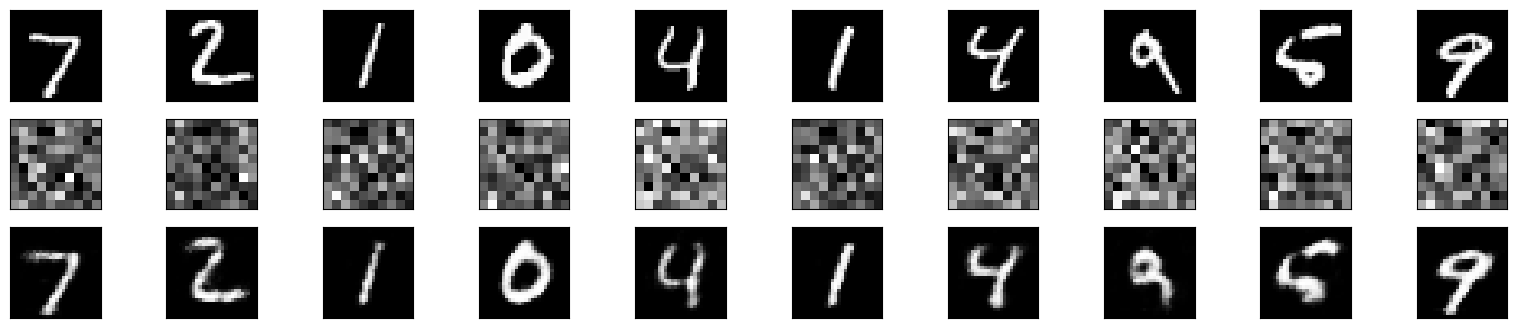

In [ ]:
del autoencoder

permutate(X_train,X_test)

autoencoder = Autoencoder_3x3(100)

history=autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=[PSNR])
autoencoder.fit(X_train, X_train,
                epochs=15,
                batch_size=512,
                shuffle=True,
                validation_data=(X_test, X_test))

encoded_imgs_test = autoencoder.encoder(X_test).numpy()
predicted_test = autoencoder.decoder(encoded_imgs_test).numpy()

# Evaluate the performance of the denoising autoencoder
evaluation_regulariced_test = autoencoder.evaluate(X_test, X_test)

print(f"Performance: Loss = {evaluation_regulariced_test[0]}, PSNR = {evaluation_regulariced_test[1]}")

plot_images(X_test,encoded_imgs_test, predicted_test, 100)

Also, at the beggining we started with a model without regularization. We are going to show it now to compare them.

Epoch 1/15
118/118 [==============================] - 11s 79ms/step - loss: 0.2554 - PSNR: 57.5118 - val_loss: 0.1571 - val_PSNR: 69.4335
Epoch 2/15
118/118 [==============================] - 8s 66ms/step - loss: 0.1361 - PSNR: 74.7922 - val_loss: 0.1187 - val_PSNR: 79.9053
Epoch 3/15
118/118 [==============================] - 9s 76ms/step - loss: 0.1132 - PSNR: 82.0625 - val_loss: 0.1061 - val_PSNR: 84.8567
Epoch 4/15
118/118 [==============================] - 9s 78ms/step - loss: 0.1034 - PSNR: 86.2875 - val_loss: 0.0983 - val_PSNR: 88.6971
Epoch 5/15
118/118 [==============================] - 8s 64ms/step - loss: 0.0969 - PSNR: 89.6216 - val_loss: 0.0936 - val_PSNR: 91.4703
Epoch 6/15
118/118 [==============================] - 9s 74ms/step - loss: 0.0928 - PSNR: 91.9992 - val_loss: 0.0903 - val_PSNR: 93.5768
Epoch 7/15
118/118 [==============================] - 8s 69ms/step - loss: 0.0900 - PSNR: 93.8376 - val_loss: 0.0882 - val_PSNR: 94.9428
Epoch 8/15
118/118 [====================

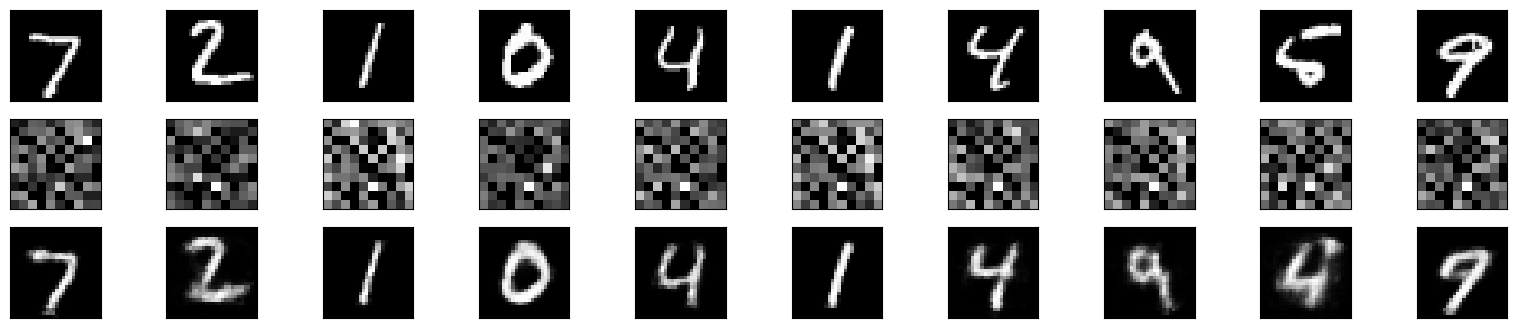

In [ ]:
del autoencoder

permutate(X_train,X_test)

autoencoder = Autoencoder_3x3(100, regularice=False) #we simply set the regularice variable to false when we create the Autoencoder object

history=autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=[PSNR])
autoencoder.fit(X_train, X_train,
                epochs=15,
                batch_size=512,
                shuffle=True,
                validation_data=(X_test, X_test))

encoded_imgs = autoencoder.encoder(X_test).numpy()
predicted = autoencoder.decoder(encoded_imgs).numpy()

# Evaluate the performance of the denoising autoencoder
evaluation_not_regulariced_test = autoencoder.evaluate(X_test, X_test)

print(f"Performance: Loss = {evaluation_not_regulariced_test[0]}, PSNR = {evaluation_not_regulariced_test[1]}")

plot_images(X_test,encoded_imgs, decoded_imgs, 100)

Compare performances on the test set

In [ ]:
for i in range(len(evaluation_regulariced_test)):
  print(evaluation_not_regulariced_test[i]-evaluation_regulariced_test[i])

-0.038027167320251465
15.795555114746094


At the beggining we worked with models with out regularization, they yield better performance because they overfited the data, as in the test set the permormance was much worst. This could be seen for example when training them with noisy data, that the denoised image was not good enough. So, to avoid overfitting and provide a more robust model, we decided to include regularization techniques. Both in the output of the encoder, where we apply Lasso regularization, and in the overall model, where we apply Elastic Net (L1_L2) regularization.

We can see how the not regulariced model reconstructs quite better the test data. But it is a price that we have to pay to avoid overfitting

# 3. Denoising autoencoder

The structure of the autoencoder is the same one, so we are going to use the one that gave us the best performance in the previous part. The only difference is that we are going to add some noise to the input data.

### 3.1 Function to add gaussian noise to the data

In [ ]:
#Create a function to add gaussian noise to data
def add_normal_zero_mean_noise_to_data(variance, data):
    data_noisy = data + np.random.normal(loc=0.0, scale=variance, size=data.shape)
    data_noisy = np.clip(data_noisy, 0., 1.) #Ensure that the data is in the interval [0,1]
    return data_noisy


## 3.2 Test our autoencoder with different variances

For that we have created a loop where on each iteraction we are going to add more noise to the data and analice how that affects the performance.



#### Comments about the output:

At each itteraction we are going to see some metrics of the different models to analice them. So, at each iteraction for each model we have:

1. Title of the variance of the noise gaussian noise added to the data
2. Training history for each model
3. Evaluation of the model (loss and PSNR)
4. A plot where we can see first the original image with out noise, below it the image with noise that has been inputed to the autoencoder, below it the lowest dimensionality encodance of the image, and at the bottom the decoded image that our denoising autoencoder predicts (with out noise).
We will see how the input data is increasinly getting more blurred/pixeled as we add more noise with higher variance.
5. Other metrics to analyce the performance of the model for different images.
6. 3 dictionarys, one for the mse, ssim and psnr metrics with the grouped data shown before

Testing variance: 0.1
Epoch 1/15
118/118 [==============================] - 10s 73ms/step - loss: 0.4608 - PSNR: 55.8392 - val_loss: 0.2590 - val_PSNR: 65.9184
Epoch 2/15
118/118 [==============================] - 9s 73ms/step - loss: 0.2169 - PSNR: 69.1749 - val_loss: 0.1890 - val_PSNR: 71.5515
Epoch 3/15
118/118 [==============================] - 9s 78ms/step - loss: 0.1745 - PSNR: 73.7415 - val_loss: 0.1629 - val_PSNR: 75.4669
Epoch 4/15
118/118 [==============================] - 7s 62ms/step - loss: 0.1574 - PSNR: 76.3908 - val_loss: 0.1532 - val_PSNR: 76.8193
Epoch 5/15
118/118 [==============================] - 9s 80ms/step - loss: 0.1494 - PSNR: 77.7560 - val_loss: 0.1472 - val_PSNR: 78.0187
Epoch 6/15
118/118 [==============================] - 8s 71ms/step - loss: 0.1438 - PSNR: 78.9488 - val_loss: 0.1407 - val_PSNR: 79.7337
Epoch 7/15
118/118 [==============================] - 8s 66ms/step - loss: 0.1386 - PSNR: 80.3739 - val_loss: 0.1361 - val_PSNR: 80.9175
Epoch 8/15
118/118

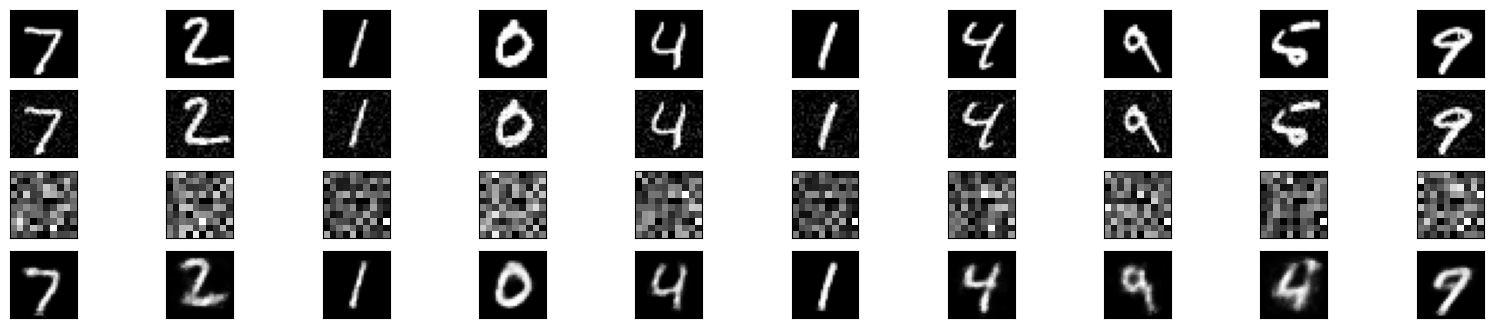

mse,ssim and psnr for image 0 are 0.011415323510484231, 0.8713400146973638 and 89.45598
mse,ssim and psnr for image 1 are 0.03592935530186923, 0.6671705480653671 and 66.52401
mse,ssim and psnr for image 2 are 0.0031453469877931696, 0.965130499576082 and 115.236626
mse,ssim and psnr for image 3 are 0.014370330310922871, 0.8933326446652954 and 84.85179
mse,ssim and psnr for image 4 are 0.013465182963233586, 0.8664274331676632 and 86.15296
mse,ssim and psnr for image 5 are 0.0026222504617706916, 0.96713908881447 and 118.87444
mse,ssim and psnr for image 6 are 0.022344859263072087, 0.7493757705442406 and 76.023186
mse,ssim and psnr for image 7 are 0.0317062455517756, 0.7125711099836906 and 69.02483
mse,ssim and psnr for image 8 are 0.07152967993470494, 0.37737145238858755 and 52.752857
mse,ssim and psnr for image 9 are 0.019105174425540414, 0.8433230042051398 and 79.15592
{7: 0.011, 2: 0.036, 1: 0.003, 0: 0.014, 4: 0.022, 9: 0.019, 5: 0.072}
{7: 0.871, 2: 0.667, 1: 0.967, 0: 0.893, 4: 0.74

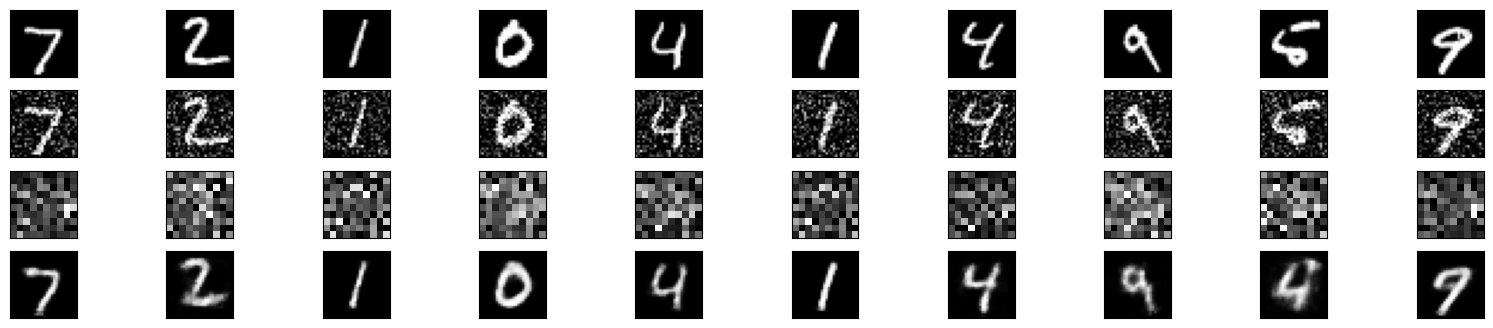

mse,ssim and psnr for image 0 are 0.011415323510484231, 0.8713400146973638 and 89.45598
mse,ssim and psnr for image 1 are 0.03592935530186923, 0.6671705480653671 and 66.52401
mse,ssim and psnr for image 2 are 0.0031453469877931696, 0.965130499576082 and 115.236626
mse,ssim and psnr for image 3 are 0.014370330310922871, 0.8933326446652954 and 84.85179
mse,ssim and psnr for image 4 are 0.013465182963233586, 0.8664274331676632 and 86.15296
mse,ssim and psnr for image 5 are 0.0026222504617706916, 0.96713908881447 and 118.87444
mse,ssim and psnr for image 6 are 0.022344859263072087, 0.7493757705442406 and 76.023186
mse,ssim and psnr for image 7 are 0.0317062455517756, 0.7125711099836906 and 69.02483
mse,ssim and psnr for image 8 are 0.07152967993470494, 0.37737145238858755 and 52.752857
mse,ssim and psnr for image 9 are 0.019105174425540414, 0.8433230042051398 and 79.15592
{7: 0.011, 2: 0.036, 1: 0.003, 0: 0.014, 4: 0.022, 9: 0.019, 5: 0.072}
{7: 0.871, 2: 0.667, 1: 0.967, 0: 0.893, 4: 0.74

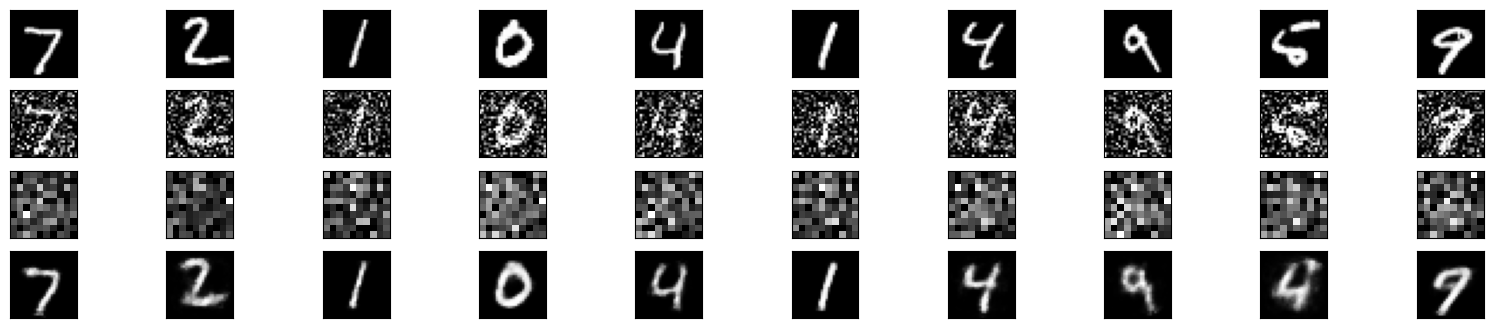

mse,ssim and psnr for image 0 are 0.011415323510484231, 0.8713400146973638 and 89.45598
mse,ssim and psnr for image 1 are 0.03592935530186923, 0.6671705480653671 and 66.52401
mse,ssim and psnr for image 2 are 0.0031453469877931696, 0.965130499576082 and 115.236626
mse,ssim and psnr for image 3 are 0.014370330310922871, 0.8933326446652954 and 84.85179
mse,ssim and psnr for image 4 are 0.013465182963233586, 0.8664274331676632 and 86.15296
mse,ssim and psnr for image 5 are 0.0026222504617706916, 0.96713908881447 and 118.87444
mse,ssim and psnr for image 6 are 0.022344859263072087, 0.7493757705442406 and 76.023186
mse,ssim and psnr for image 7 are 0.0317062455517756, 0.7125711099836906 and 69.02483
mse,ssim and psnr for image 8 are 0.07152967993470494, 0.37737145238858755 and 52.752857
mse,ssim and psnr for image 9 are 0.019105174425540414, 0.8433230042051398 and 79.15592
{7: 0.011, 2: 0.036, 1: 0.003, 0: 0.014, 4: 0.022, 9: 0.019, 5: 0.072}
{7: 0.871, 2: 0.667, 1: 0.967, 0: 0.893, 4: 0.74

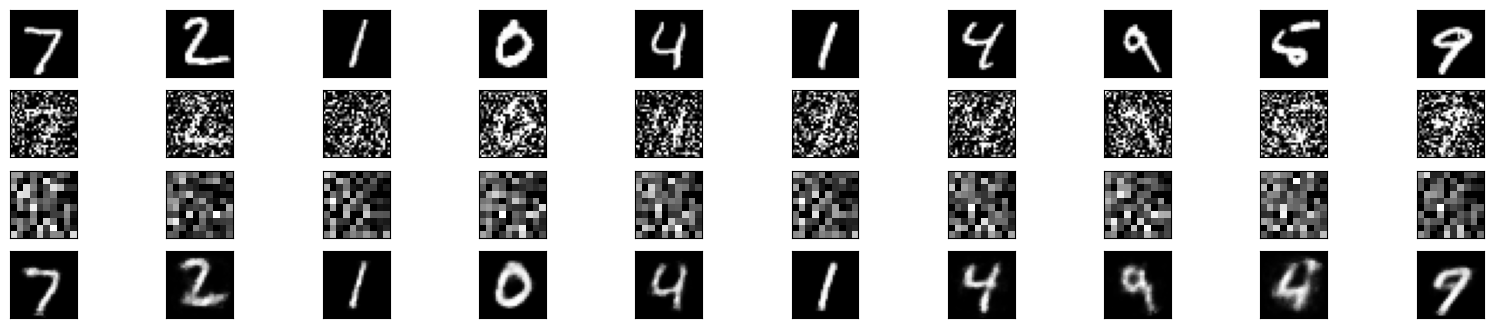

mse,ssim and psnr for image 0 are 0.011415323510484231, 0.8713400146973638 and 89.45598
mse,ssim and psnr for image 1 are 0.03592935530186923, 0.6671705480653671 and 66.52401
mse,ssim and psnr for image 2 are 0.0031453469877931696, 0.965130499576082 and 115.236626
mse,ssim and psnr for image 3 are 0.014370330310922871, 0.8933326446652954 and 84.85179
mse,ssim and psnr for image 4 are 0.013465182963233586, 0.8664274331676632 and 86.15296
mse,ssim and psnr for image 5 are 0.0026222504617706916, 0.96713908881447 and 118.87444
mse,ssim and psnr for image 6 are 0.022344859263072087, 0.7493757705442406 and 76.023186
mse,ssim and psnr for image 7 are 0.0317062455517756, 0.7125711099836906 and 69.02483
mse,ssim and psnr for image 8 are 0.07152967993470494, 0.37737145238858755 and 52.752857
mse,ssim and psnr for image 9 are 0.019105174425540414, 0.8433230042051398 and 79.15592
{7: 0.011, 2: 0.036, 1: 0.003, 0: 0.014, 4: 0.022, 9: 0.019, 5: 0.072}
{7: 0.871, 2: 0.667, 1: 0.967, 0: 0.893, 4: 0.74

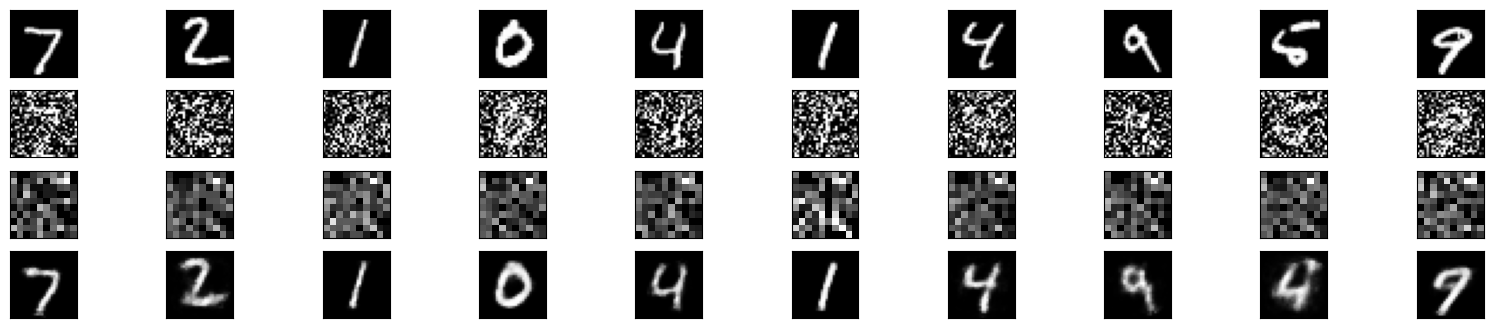

mse,ssim and psnr for image 0 are 0.011415323510484231, 0.8713400146973638 and 89.45598
mse,ssim and psnr for image 1 are 0.03592935530186923, 0.6671705480653671 and 66.52401
mse,ssim and psnr for image 2 are 0.0031453469877931696, 0.965130499576082 and 115.236626
mse,ssim and psnr for image 3 are 0.014370330310922871, 0.8933326446652954 and 84.85179
mse,ssim and psnr for image 4 are 0.013465182963233586, 0.8664274331676632 and 86.15296
mse,ssim and psnr for image 5 are 0.0026222504617706916, 0.96713908881447 and 118.87444
mse,ssim and psnr for image 6 are 0.022344859263072087, 0.7493757705442406 and 76.023186
mse,ssim and psnr for image 7 are 0.0317062455517756, 0.7125711099836906 and 69.02483
mse,ssim and psnr for image 8 are 0.07152967993470494, 0.37737145238858755 and 52.752857
mse,ssim and psnr for image 9 are 0.019105174425540414, 0.8433230042051398 and 79.15592
{7: 0.011, 2: 0.036, 1: 0.003, 0: 0.014, 4: 0.022, 9: 0.019, 5: 0.072}
{7: 0.871, 2: 0.667, 1: 0.967, 0: 0.893, 4: 0.74

In [ ]:
# Define the range of variances to test
variances = [0.1, 0.3, 0.5, 0.7, 0.9]
latent_dim=100
losses = []
PSNRs = []

# Loop over each variance
for variance in variances:

    if autoencoder:
      del autoencoder

    permutate(X_train,X_test)

    print(f"Testing variance: {variance}")

    X_train_noisy = add_normal_zero_mean_noise_to_data(variance, X_train)
    X_test_noisy = add_normal_zero_mean_noise_to_data(variance, X_test)

    # Create and train the denoising autoencoder
    autoencoder = Autoencoder_3x3(latent_dim)

    history=autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                            metrics=[PSNR])
    autoencoder.fit(X_train_noisy, X_train,
                    epochs=15,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(X_test_noisy, X_test))

    # reconstructing the image from autoencoder and encoder
    encoded_imgs = autoencoder.encoder(X_test_noisy).numpy()
    predicted = autoencoder.decoder(encoded_imgs).numpy()

    # Evaluate the performance of the denoising autoencoder
    evaluation = autoencoder.evaluate(X_test_noisy, X_test)
    losses.append(evaluation[0])
    PSNRs.append(evaluation[1])
    print(f"Performance for variance {variance}: Loss = {evaluation[0]}, PSNR = {evaluation[1]}")

    plot_images(X_test,encoded_imgs, decoded_imgs, latent_dim, noisy=True)

    #Another way to see it
    decomser = {}
    decossimr = {}
    decopsnr = {}
    n = 10
    list_xtestn = [ [X_test[i], y_test[i]] for i in range(10)]

    for i in range(n):

        msel = mse(list_xtestn[i][0],decoded_imgs[i])
        decomser[list_xtestn[i][1]]=round(msel,3)

        ssiml = ssim(list_xtestn[i][0],decoded_imgs[i])
        decossimr[list_xtestn[i][1]]=round(ssiml,3)

        psnr = PSNR(list_xtestn[i][0],decoded_imgs[i]).numpy()
        decopsnr[list_xtestn[i][1]]=round(psnr,3)

        print("mse,ssim and psnr for image %s are %s, %s and %s" %(i,msel,ssiml, psnr))

    print(decomser)
    print(decossimr)
    print(decopsnr)

## Performance vs Variance plots

Finally, we have two plots to analyce the performance of the model with respect to noises with different variance level.

As it is obvious, the performance gets worse as the variance increases.

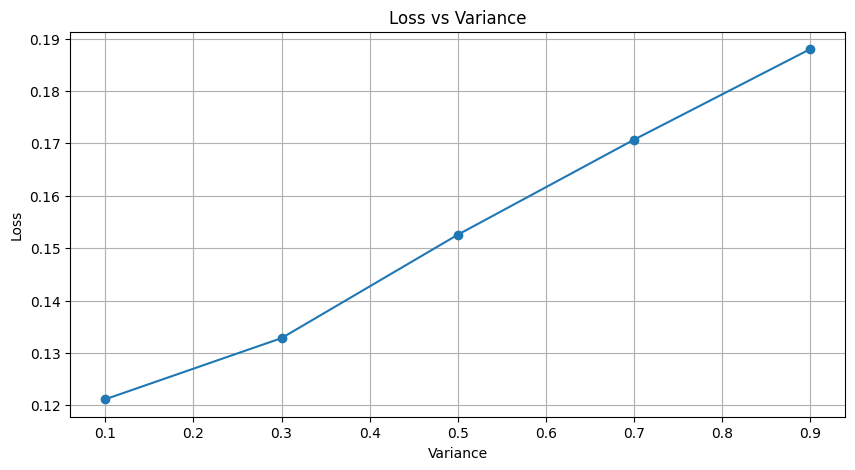

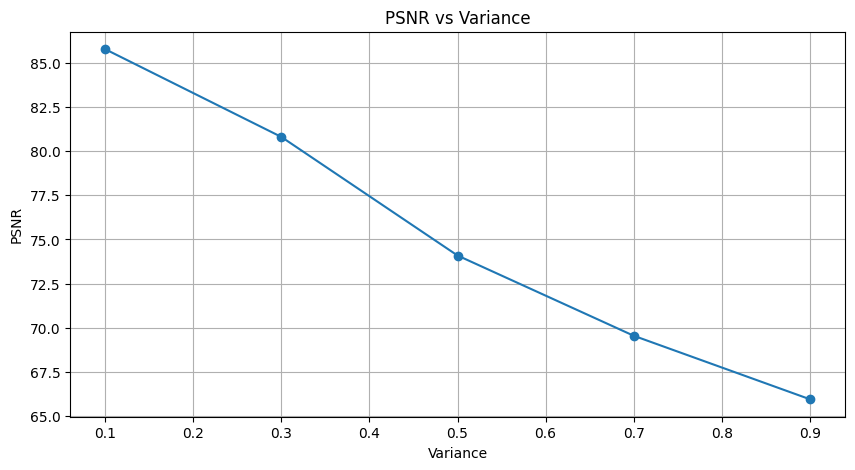

In [ ]:
# Plot loss vs variances
plt.figure(figsize=(10, 5))
plt.plot(variances, losses, marker='o')
plt.title('Loss vs Variance')
plt.xlabel('Variance')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot PSNR vs variances
plt.figure(figsize=(10, 5))
plt.plot(variances, PSNRs, marker='o')
plt.title('PSNR vs Variance')
plt.xlabel('Variance')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()